In [853]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error


In [854]:
df = pd.read_csv('Bengaluru_House_Data.csv')

In [855]:
df = df.drop(columns=['availability', 'society'])

In [856]:
df = df.dropna()

In [857]:
df.head()

,area_type,location,size,total_sqft,bath,balcony,price
0,Super built-up Area,Electronic City Phase II,2 BHK,1056,2.0,1.0,39.07
1,Plot Area,Chikka Tirupathi,4 Bedroom,2600,5.0,3.0,120.00
2,Built-up Area,Uttarahalli,3 BHK,1440,2.0,3.0,62.00
3,Super built-up Area,Lingadheeranahalli,3 BHK,1521,3.0,1.0,95.00
4,Super built-up Area,Kothanur,2 BHK,1200,2.0,1.0,51.00


In [858]:
def convert_sqft(val):
    if '-' in val:
        low,high=val.split('-')
        return (float(low)+float(high))/2
    elif 'Sq. Meter' in val:
         return np.nan
    elif 'Perch' in val:
         return np.nan
    elif 'Sq. Yards' in val:
         return np.nan
    elif 'Acres' in val:
         return np.nan
    elif 'Cents' in val:
         return np.nan
    elif 'Guntha' in val:
         return np.nan
    elif 'Grounds' in val:
         return np.nan
    else:
        return float(val)


df['total_sqft']= df['total_sqft'].apply(convert_sqft)

In [859]:
df = df.dropna(subset=['total_sqft'])


In [860]:
def extract_bhk(val):
    if isinstance(val, str):
        return int(val.split()[0])
    else:
        return np.nan

df['bhk'] = df['size'].apply(extract_bhk)

In [861]:
df = df.drop(columns=['size'])

In [862]:
df = df[df['total_sqft']/df['bhk']>=300]


In [863]:
df.shape

(12013, 7)

In [864]:
df['bhk'].describe()
# df['bhk'].isna().sum()
# df['bhk'].value_counts().head(10)



count    12013.000000
mean         2.607259
std          0.922985
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max         13.000000
Name: bhk, dtype: float64

In [865]:
df['area_type'].value_counts()

area_type
Super built-up  Area    8430
Built-up  Area          2235
Plot  Area              1270
Carpet  Area              78
Name: count, dtype: int64

In [866]:
df.isnull().mean()*100

area_type     0.0
location      0.0
total_sqft    0.0
bath          0.0
balcony       0.0
price         0.0
bhk           0.0
dtype: float64

In [867]:
# df['total_sqft'].str.contains('-', regex=False)


In [868]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12013 entries, 0 to 13319
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   area_type   12013 non-null  object 
 1   location    12013 non-null  object 
 2   total_sqft  12013 non-null  float64
 3   bath        12013 non-null  float64
 4   balcony     12013 non-null  float64
 5   price       12013 non-null  float64
 6   bhk         12013 non-null  int64  
dtypes: float64(4), int64(1), object(2)
memory usage: 750.8+ KB


In [869]:
df['price_per_sqft'] = price_per_sqft = df['price'] / df['total_sqft']


In [870]:
def remove_pps_outliers(df):
    clean_df = pd.DataFrame()

    for location, location_df in df.groupby("location"):

        mean_pps = location_df.price_per_sqft.mean()
        std_pps = location_df.price_per_sqft.std()

        lower_limit = mean_pps - std_pps
        upper_limit = mean_pps + std_pps

        filtered_df = location_df[
            (location_df.price_per_sqft > lower_limit) &
            (location_df.price_per_sqft <= upper_limit)
        ]

        clean_df = pd.concat([clean_df, filtered_df], ignore_index=True)

    return clean_df


# Function call
df = remove_pps_outliers(df)


In [871]:
df['price_per_sqft'].sample(10)

6412    0.052083
1423    0.042031
6657    0.033897
2747    0.053078
57      0.060976
1565    0.039175
6636    0.053000
2540    0.051471
114     0.035185
331     0.059091
Name: price_per_sqft, dtype: float64

In [872]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9242 entries, 0 to 9241
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   area_type       9242 non-null   object 
 1   location        9242 non-null   object 
 2   total_sqft      9242 non-null   float64
 3   bath            9242 non-null   float64
 4   balcony         9242 non-null   float64
 5   price           9242 non-null   float64
 6   bhk             9242 non-null   int64  
 7   price_per_sqft  9242 non-null   float64
dtypes: float64(5), int64(1), object(2)
memory usage: 577.8+ KB


In [873]:
df.describe()

,total_sqft,bath,balcony,price,bhk,price_per_sqft
count,9242.000000,9242.000000,9242.000000,9242.000000,9242.000000,9242.000000
mean,1467.199786,2.429236,1.594460,90.043949,2.528024,0.056698
std,790.921708,0.908914,0.794829,96.874203,0.819709,0.024879
min,300.000000,1.000000,0.000000,10.000000,1.000000,0.012500
25%,1100.000000,2.000000,1.000000,48.232500,2.000000,0.042368
50%,1270.000000,2.000000,2.000000,65.000000,2.000000,0.051471
75%,1611.000000,3.000000,2.000000,97.000000,3.000000,0.063492
max,30400.000000,9.000000,3.000000,2912.000000,9.000000,0.349958


In [874]:
df.shape

(9242, 8)

In [875]:
df['area_type'].value_counts()

area_type
Super built-up  Area    6900
Built-up  Area          1709
Plot  Area               584
Carpet  Area              49
Name: count, dtype: int64

In [876]:
loc_counts = df['location'].value_counts()
rare_counts = loc_counts[loc_counts<10].index

df.loc[df['location'].isin(rare_counts),'location']='other'

In [877]:
df['location'].value_counts()

location
other               1924
Whitefield           464
Sarjapur  Road       287
Electronic City      277
Kanakpura Road       187
                    ... 
Murugeshpalya         10
Rajiv Nagar           10
LB Shastri Nagar      10
Mico Layout           10
Sarakki Nagar         10
Name: count, Length: 189, dtype: int64

In [878]:
df.head()

,area_type,location,total_sqft,bath,balcony,price,bhk,price_per_sqft
0,Super built-up Area,other,1100.0,2.0,1.0,70.0,2,0.063636
1,Super built-up Area,other,1672.0,3.0,2.0,150.0,3,0.089713
2,Built-up Area,other,1750.0,3.0,3.0,149.0,3,0.085143
3,Super built-up Area,other,1750.0,3.0,2.0,150.0,3,0.085714
4,Super built-up Area,Devarachikkanahalli,1250.0,2.0,3.0,44.0,3,0.035200


In [879]:
df.isnull().mean()*100


area_type         0.0
location          0.0
total_sqft        0.0
bath              0.0
balcony           0.0
price             0.0
bhk               0.0
price_per_sqft    0.0
dtype: float64

In [880]:
# bath > bhk + 2 → drop
df= df[df['bath']<=df['bhk']+2]

In [881]:
df.shape

(9239, 8)

In [882]:
# df = df.drop(columns=['size'])
df = df.dropna()

In [883]:
X = df.drop(columns=['price', 'price_per_sqft'])
y = df['price']

In [884]:
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.2,random_state=42)

In [885]:
trf = ColumnTransformer(transformers=[
    ('area_type',OneHotEncoder(drop='first',sparse_output=False,handle_unknown='ignore'),['area_type']),
    ('location',OneHotEncoder(drop='first',sparse_output=False,handle_unknown='ignore'),['location']),
     ('balcony',SimpleImputer(strategy='mean'),['balcony']),
     ('bath',SimpleImputer(strategy='mean'),['bath'])
],remainder='passthrough')

In [886]:
pipe = Pipeline([
    ('preprocess',trf),
    ('model',XGBRegressor(n_estimators=500,learning_rate=0.05, max_depth=4,reg_alpha=1,reg_lambda=1,n_jobs=4))
])

In [887]:
params = {
    'model__n_estimators': [500, 900, 1100], 
    'model__learning_rate': [0.01, 0.03, 0.05],
    'model__max_depth': [3, 5, 10]
}

In [888]:
grid = GridSearchCV(estimator=pipe, param_grid=params, 
                    cv=5, n_jobs=-1, verbose=2)

In [889]:
grid.fit(X_train, np.log(y_train))

Fitting 5 folds for each of 27 candidates, totalling 135 fits


d:\Miniconda3\Lib\site-packages\sklearn\compose\_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('area_type',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['area_type']),
                                                                        ('location',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['location']),
                                                                        ('balcony',
                                                                         SimpleImputer(),
                                                                         ['balcony']...
                                                     max_cat_threshold=None,
                                                     max_cat_to_onehot=None,
                                                     max_delta_step=None,
                                                     max_depth=4,
                                                     max_leaves=None,
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     multi_strategy=None,
                                                     n_estimators=500, n_jobs=4,
                                                     num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'model__learning_rate': [0.01, 0.03, 0.05],
                         'model__max_depth': [3, 5, 10],
                         'model__n_estimators': [500, 900, 1100]},
             verbose=2)

In [890]:
print("Best Params:", grid.best_params_)

Best Params: {'model__learning_rate': 0.05, 'model__max_depth': 5, 'model__n_estimators': 1100}


In [891]:
print("Best Score:", grid.best_score_)

Best Score: 0.8474536393440857


In [892]:
pipe = grid.best_estimator_

In [893]:
y_pred_log = pipe.predict(X_test)

In [894]:
y_pred = np.exp(y_pred_log)

In [895]:
print("Tuned Model R2 Score:", r2_score(y_test, y_pred))

Tuned Model R2 Score: 0.7878275971203206


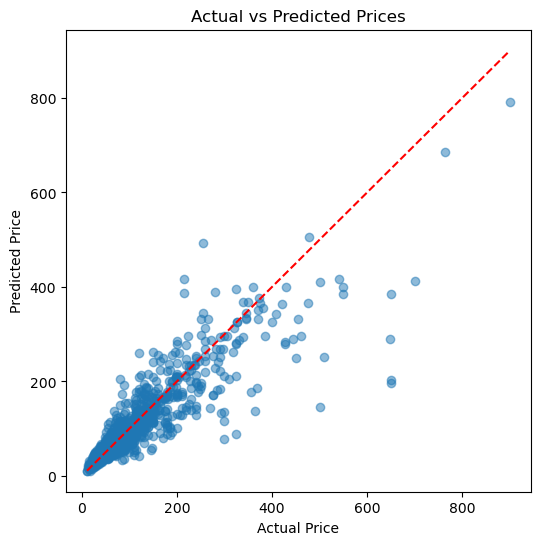

In [896]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Prices")
plt.show()

In [897]:
import joblib

# Ensure 'pipe' is your trained XGBoost pipeline
joblib.dump(pipe, "bengaluru_house_price_final.pkl")

print("File saved successfully! Now move this file to your app folder.")

File saved successfully! Now move this file to your app folder.
